# Project-7: Временные ряды
## Задание №1
### Постановка задачи.
Проанализировать ВВП африканской страны Гана (данные за 62 года). Исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [35]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

from warnings import filterwarnings
filterwarnings("ignore")

1.1. Читаем исходный файл с данными. Визуализируем исходный временной ряд, делаем первичные выводы о присутствии компонент тренда и сезонности в ряде.

In [36]:
data = pd.read_csv("../data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
display(data)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


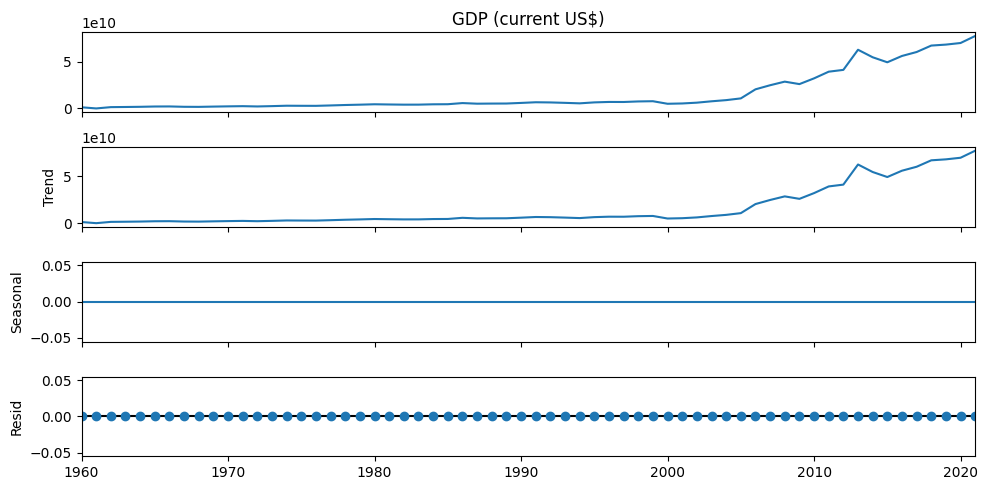

In [37]:
plt.rcParams["figure.figsize"] = 10, 5
#производим декомпозицию временного ряда 
result = seasonal_decompose(data['GDP (current US$)'])
result.plot()
plt.show()

По графикам видим, что в данном временном ряде отсутствуют шум и сезонность, что в свою очередь обусловлено природой предоставленных данных (ВВП африканской страны).

Отложим последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [38]:
X_train = data.loc[:"2018-01-01"]
X_test = data.loc["2019-01-01":]
X_train.shape, X_test.shape

((59, 1), (3, 1))

1.2. Построим график скользящего среднего и проанализируем результат. Для построения MA будем использовать метод rolling(), который принимает в качестве параметра размер окна. Будем использовать среднее как функцию для сглаживания. Ширину окна подберем произвольно.

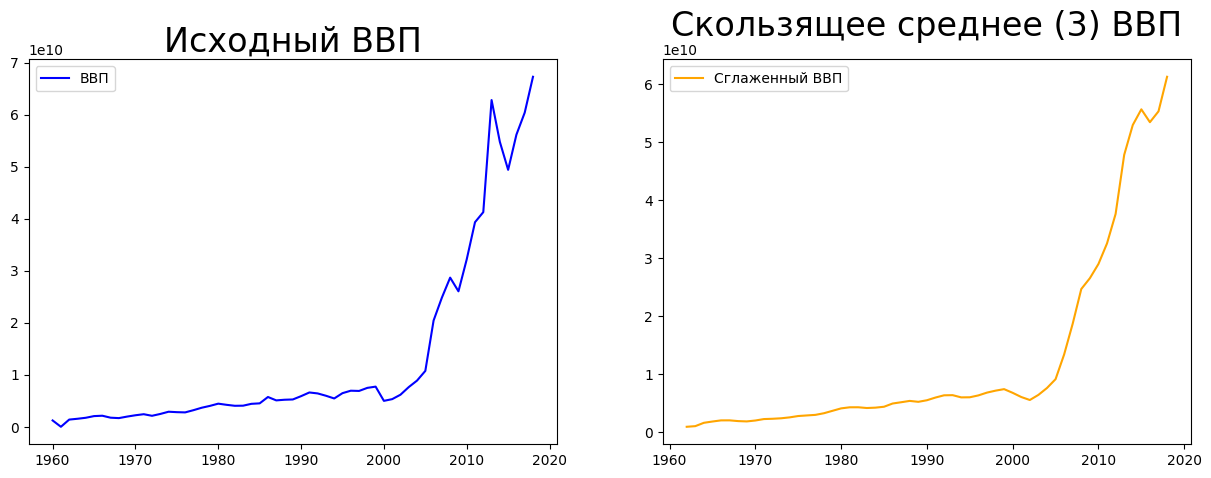

In [39]:
plt.rcParams["figure.figsize"] = 15, 5

fig, ax = plt.subplots(1, 2)

ax[0].plot(X_train['GDP (current US$)'], color="blue", label='ВВП')
ax[0].set_title("Исходный ВВП", size=24)
ax[0].legend()

ax[1].plot(
    X_train['GDP (current US$)'].rolling(window=3).mean(),
    color="orange",
    label="Сглаженный ВВП",
)
ax[1].set_title("Скользящее среднее (3) ВВП", size=24)
ax[1].legend()
plt.show()


Как по исходному, так и по сглаженному графику можно сделать вывод, что в течении всего рассматриваемого периода наблюдается рост ВВП Ганы, при этом за последние 15 лет произошло резкое увеличение роста рассматриваемой величины.

1.3. С помощью теста Дики-Фуллера оценим стационарность временного ряда и примем решение о выборе модели ARMA/ARIMA.

In [40]:
result = adfuller(X_train['GDP (current US$)']) 

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: 0.6529066974885371
p-value: 0.9888496277665573
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600


С помощью теста Дики-Фуллера нашли значение статистики ADF Statistic = 0.65, которое больше критических значений, поэтому мы принимаем гипотезу H0, - временной ряд нестационарный. Будем дифференцировать его до тех пор, пока не получим стационарный. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет нашим параметром d для модели ARIMA.

In [41]:
d=1
X_train_tmp = X_train['GDP (current US$)']
while True:
    X_diff = X_train_tmp.diff().dropna()
    test = adfuller(X_diff)
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('ряд нестационарен')
        d=d+1
        X_train_tmp = X_diff
    else:
        print ('ряд стационарен, d =', d)
        break

adf:  -1.6702483038320772
p-value:  0.4465029329713892
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен
adf:  -2.6408690561284955
p-value:  0.08484116917837553
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен
adf:  -4.7796237848285426
p-value:  5.948327640224631e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен, d = 3


Так как d = 3, то исходный временной ряд является интегрированным рядом третьего порядка.

Параметры p и q выберем по коррелограммам ACF и PACF (которые построим для стационарного ряда).

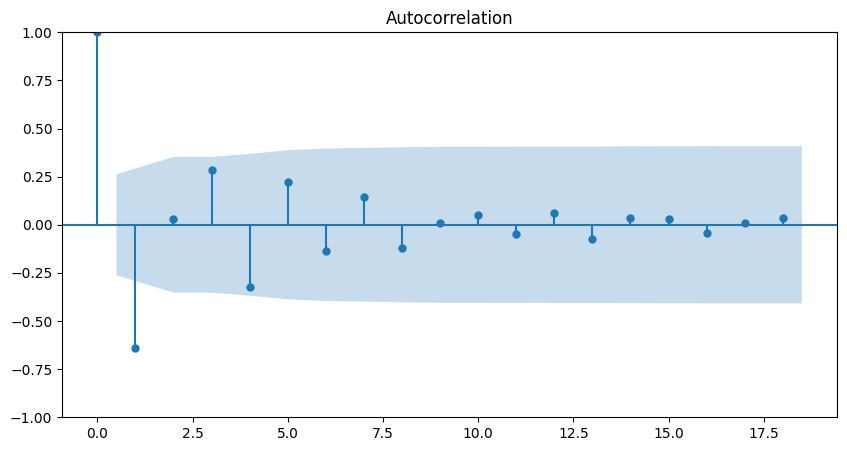

In [42]:
plt.rcParams["figure.figsize"] = 10, 5
sgt.plot_acf(X_diff)
plt.show()

По графику, выбираем p = 1. Так же видим, что есть явно выраженный тренд, так как в единице модуль лага максимален. Данные ряда, кроме первого лага, случайны и не зависят от себя в прошлом. 

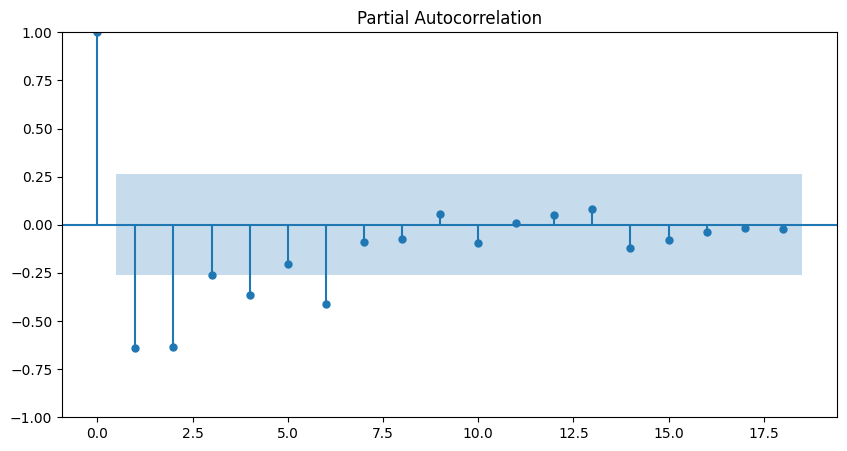

In [43]:
plt.rcParams["figure.figsize"] = 10, 5
sgt.plot_pacf(X_diff) 
plt.show()

По графику частичной автокорреляции мы могли бы определить сезонный период для нашего ряда, однако ранее мы выяснили, что сезонность в данных отсутствует.
Определяем лаг, сильно отличный от нуля, - это p = 1 и 2. Поэтому проверим эти два параметра на модели и сравним результаты. 

Построим модель для прогнозирования поведения временного ряда. Т.к. мы имеем нестационарный временной ряд, то применим к нему модель ARIMA с параметром d=3 (порядок дифференцирования, который мы определили ранее). Параметр q для скользящего среднего выберем произвольно (q = 3).

In [44]:
arima_model = ARIMA(X_train['GDP (current US$)'], order=(1, 3, 3)) # p, d, q 
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 3, 3)   Log Likelihood               -1326.865
Date:                Mon, 16 Oct 2023   AIC                           2663.730
Time:                        08:03:01   BIC                           2673.857
Sample:                    01-01-1960   HQIC                          2667.656
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7887      0.691     -1.142      0.253      -2.142       0.565
ma.L1         -0.8903      1.095     -0.813      0.416      -3.037       1.256
ma.L2         -0.8940      1.009     -0.886      0.3

In [45]:
arima_model = ARIMA(X_train['GDP (current US$)'], order=(2, 3, 3)) # p, d, q 
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 3)   Log Likelihood               -1319.181
Date:                Mon, 16 Oct 2023   AIC                           2650.363
Time:                        08:03:01   BIC                           2662.515
Sample:                    01-01-1960   HQIC                          2655.074
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0335      0.163     -6.323      0.000      -1.354      -0.713
ar.L2         -0.3396      0.245     -1.386      0.166      -0.820       0.141
ma.L1         -0.8609      0.238     -3.618      0.0

Сравним две модели ARIMA(1,3,3) и ARIMA(2,3,3). Коэффециенты Акаике соответственно равны AIC=2663 и AIC=2650. Вторая модель с наименьшем AIC предпочтительнее. Однако, подберем наилучшие параметры с помощью пакета pmdarima, и будем использовать именно их.

In [46]:
smodel = pm.auto_arima(
    X_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=3,    
    error_action="ignore",
    test="adf",
    trace=True,
    seasonal=False,
    stepwise=False
)

smodel.summary()

 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.03 sec


 ARIMA(0,3,2)(0,0,0)[0]             : AIC=2664.759, Time=0.04 sec
 ARIMA(0,3,3)(0,0,0)[0]             : AIC=2689.154, Time=0.04 sec
 ARIMA(0,3,4)(0,0,0)[0]             : AIC=2681.735, Time=0.08 sec
 ARIMA(0,3,5)(0,0,0)[0]             : AIC=2670.864, Time=0.14 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.03 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,3,3)(0,0,0)[0]             : AIC=2663.730, Time=0.05 sec
 ARIMA(1,3,4)(0,0,0)[0]             : AIC=2659.502, Time=0.12 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.02 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,3,3)(0,0,0)[0]             : AIC=2650.363, Time=0.09 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(4, 3, 1)   Log Likelihood               -1317.968
Date:                Mon, 16 Oct 2023   AIC                           2647.936
Time:                        08:03:03   BIC                           2660.088
Sample:                    01-01-1960   HQIC                          2652.647
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9270      0.157     -5.889      0.000      -1.235      -0.618
ar.L2         -0.9256      0.358     -2.589      0.010      -1.626      -0.225
ar.L3         -0.6488      0.377     -1.720      0.085      -1.388       0.090
ar.L4         -0.5489      0.323     -1.701      0.089      -1.181       0.084
ma.L1         -0.9669      0.163     -5.926      0.000      -1.287      -0.647
sigma2      2.367e+19   7.93e-21   2.99e+39      0.000    2.37e+19    2.37e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               244.30
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):             208.15   Skew:                             1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+55. Standard errors may be unstable.
"""

1.4. Построим модель с наилучшими параметрами и выполним предсказание для отложенной тестовой выборки (последние три года).

In [47]:
arima_model = ARIMA(X_train['GDP (current US$)'], order=(4, 3, 1)) # p, d, q 
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(4, 3, 1)   Log Likelihood               -1317.968
Date:                Mon, 16 Oct 2023   AIC                           2647.936
Time:                        08:03:03   BIC                           2660.088
Sample:                    01-01-1960   HQIC                          2652.647
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9270      0.157     -5.889      0.000      -1.235      -0.618
ar.L2         -0.9256      0.358     -2.589      0.010      -1.626      -0.225
ar.L3         -0.6488      0.377     -1.720      0.0

In [48]:
pred_df = pd.DataFrame(index=X_test.index)

pred_df["model_preds"] = arima_model_fit.predict(start=X_test.index[0], end=X_test.index[-1])
pred_df["GDP (current US$)"] = X_test["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(X_test.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[X_test.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[X_test.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

display(pred_df)

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
2019-01-01,6.484881e+10,6.833754e+10,5.530542e+10,7.439221e+10
2020-01-01,6.369768e+10,7.004320e+10,4.945741e+10,7.793796e+10
2021-01-01,6.977208e+10,7.759428e+10,5.178734e+10,8.775682e+10


1.5. Отобразим результат графически — построим графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

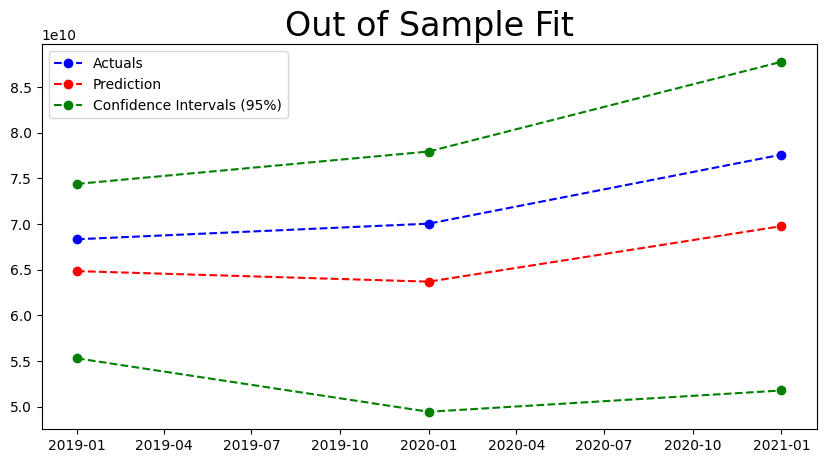

In [49]:
plt.rcParams["figure.figsize"] = 10, 5

plt.subplot()
plt.plot(
    pred_df.loc[X_test.index]["GDP (current US$)"], color="blue", label="Actuals", linestyle="--", marker='o',
)
plt.plot(
    pred_df.loc[X_test.index]["model_preds"],
    color="red",
    linestyle="--",
    marker='o',
    label="Prediction"
)
plt.plot(
    pred_df.loc[X_test.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    marker='o',
    label="Confidence Intervals (95%)"
)
plt.plot(
    pred_df.loc[X_test.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    marker='o'    
)
plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

1.6. Выводы по полученным результатам.

Предсказанные значения ВВП Ганы за последние три года (2019-2021) попадают в доверительный интервал с доверительной вероятностью 95%, так же видим, что модель уловила тренд временного ряда (но стоило бы проверить этот вывод на большем количестве входных данных).

## Задание №2
### Интерполяция

2.1. Проверим данные на наличие пропущенных дат с помощью метода DataFrame.asfreq()

In [50]:
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


В данных нет пропущенных дат.

2.2. Проверим данные на наличие пропущенных значений.

In [51]:
data['GDP (current US$)'].isna().sum()

0

Явных пропусков в данных нет

2.3. Обратим внимание, что есть нулевые значения в столбце 'GDP (current US$)'. Сделаем проверку на наличие нулевых значений и в случае нахождения заменим их на NaN.

In [52]:
import numpy as np
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
data['GDP (current US$)'].isna().sum()

1

В данных появилось одно явно пропущенное значение (Nan)

2.4. Для заполнения пропусков выполним интерполяцию с использованием метода .interpolate().

In [53]:
data_int = data
data_int['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')
display(data_int)

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


2.5. Проверим полученный ряд на стационарность (тест Дики-Фуллера), определим параметры модели (ARIMA/ARMA) и построим модель.

In [54]:
X_train = data_int.loc[:"2018-01-01"]
X_test = data_int.loc["2019-01-01":]
	
d=1
X_train_tmp = X_train['GDP (current US$)']
while True:
    X_diff = X_train_tmp.diff().dropna()
    test = adfuller(X_diff)
    print ('adf: ', test[0])
    print ('p-value: ', test[1])
    print ('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('ряд нестационарен')
        d=d+1
        X_train_tmp = X_diff
    else:
        print ('ряд стационарен, d =', d)
        break

adf:  -1.825565224643601
p-value:  0.36784515276563373
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен
adf:  -2.6346347460078547
p-value:  0.08604813722197441
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен
adf:  -4.825603687304035
p-value:  4.857318076799631e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен, d = 3


In [55]:
smodel = pm.auto_arima(
    X_train,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=3,    
    error_action="ignore",
    test="adf",
    trace=True,
    seasonal=False,
    stepwise=False
)

smodel.summary()

 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.03 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=2664.967, Time=0.05 sec
 ARIMA(0,3,3)(0,0,0)[0]             : AIC=2691.449, Time=0.05 sec


 ARIMA(0,3,4)(0,0,0)[0]             : AIC=2681.750, Time=0.12 sec
 ARIMA(0,3,5)(0,0,0)[0]             : AIC=2670.456, Time=0.21 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.03 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,3,3)(0,0,0)[0]             : AIC=2665.413, Time=0.04 sec
 ARIMA(1,3,4)(0,0,0)[0]             : AIC=2659.692, Time=0.12 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.09 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,3,3)(0,0,0)[0]             : AIC=2651.078, Time=0.08 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.02 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.04 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=2663.433, Time=0.05 sec
 ARIMA(4,3,1)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(4, 3, 1)   Log Likelihood               -1317.908
Date:                Mon, 16 Oct 2023   AIC                           2647.817
Time:                        08:03:05   BIC                           2659.969
Sample:                    01-01-1960   HQIC                          2652.528
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9263      0.156     -5.952      0.000      -1.231      -0.621
ar.L2         -0.9275      0.352     -2.633      0.008      -1.618      -0.237
ar.L3         -0.6500      0.372     -1.749      0.080      -1.378       0.078
ar.L4         -0.5525      0.315     -1.752      0.080      -1.171       0.066
ma.L1         -0.9667      0.160     -6.044      0.000      -1.280      -0.653
sigma2      2.365e+19   8.94e-21   2.64e+39      0.000    2.36e+19    2.36e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               245.19
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):             524.14   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.76e+55. Standard errors may be unstable.
"""

2.6. Ответим на вопрос: "Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных?"

Произошло незначительное уменьшение коэффициента AIC на интерполированных данных по сравнению с неинтерполированными на 0,1. Согласно полученному результату и здравому смыслу, можно сделать вывод, что интерполяция пропущенных данных, улучшает качество модели.

## Задание №3
### Предсказание волатильности


3.1. Посчитаем волатильность нашего временного ряда.

,GDP (current US$),gdp_vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
...,...,...
2017-01-01,6.040638e+10,7.551317
2018-01-01,6.729928e+10,11.410877
2019-01-01,6.833754e+10,1.542746


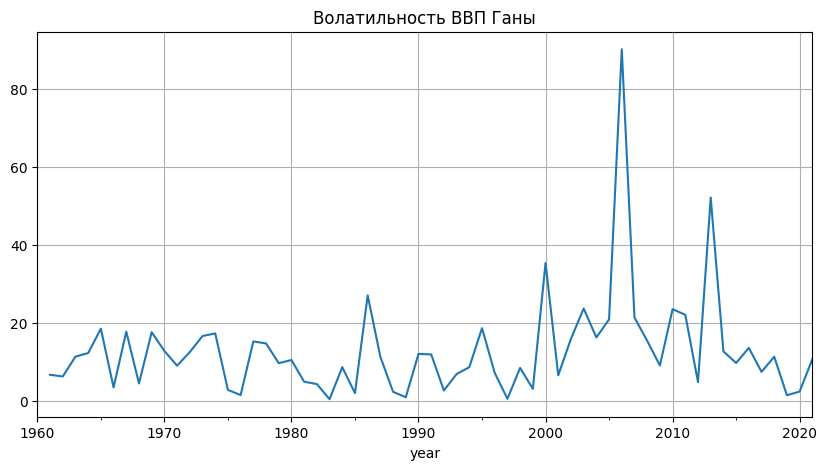

In [56]:
data["gdp_vol"] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
display(data)
data["gdp_vol"].plot()
plt.title("Волатильность ВВП Ганы")
plt.grid()
plt.show()

По графику видим, что значения волатильности, в большинстве временных точках, принимает большие значения.  

3.2. Воспользуемся GARCH-моделью для предсказания волатильности (её дисперсии).

In [57]:
X_train = (data.loc[:"2018-01-01"]).drop(['GDP (current US$)'], axis=1)
X_test = (data.loc["2019-01-01":]).drop(['GDP (current US$)'], axis=1)
X_train.shape, X_test.shape

((59, 1), (3, 1))

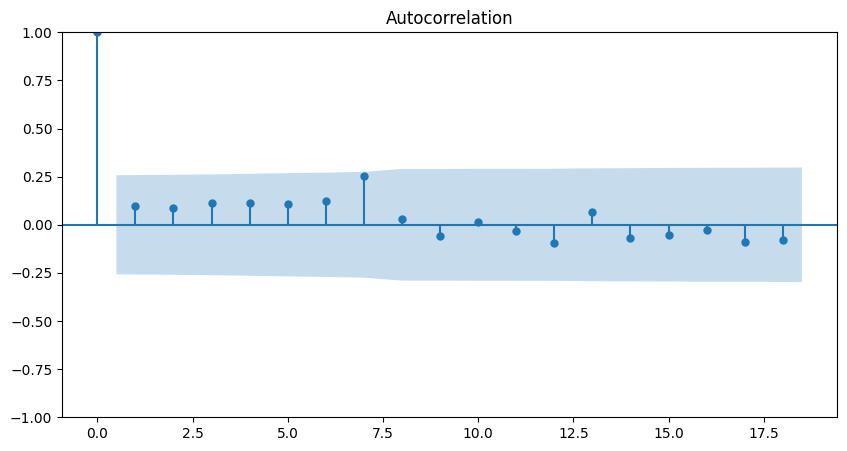

In [58]:
plt.rcParams["figure.figsize"] = 10, 5
sgt.plot_acf(X_train['gdp_vol'][1:]) # ['gdp_vol']
plt.show()

In [59]:
adfuller(X_train['gdp_vol'][1:])

(-6.725311059553778,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

Глядя на график автокорреляции (ACF) для волатильности ВВП, видим, что уровни значимости начиная с 1 колеблются в районе 0. При этом, ряд является стационарным (следует из теста Дики-Фуллера).

In [60]:
garch_df = data.drop('GDP (current US$)', axis=1)
#display(garch_df)
model = arch_model(garch_df["gdp_vol"].dropna(), p=2, q=2, vol="GARCH")

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки
model_results = model.fit(last_obs=X_test.index[0], update_freq=5)

Iteration:      5,   Func. Count:     39,   Neg. LLF: 228.6095884373151
Iteration:     10,   Func. Count:     74,   Neg. LLF: 226.7262980616956
Iteration:     15,   Func. Count:    109,   Neg. LLF: 226.6994206641058
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.5978300547896
            Iterations: 19
            Function evaluations: 139
            Gradient evaluations: 19


In [61]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           465.196
Method:            Maximum Likelihood   BIC:                           477.558
                                        No. Observations:                   58
Date:                Mon, Oct 16 2023   Df Residuals:                       57
Time:                        08:03:05   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3129      2.221      5.545  2.946e-08 [  7.960, 16.665]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6689     17.107      0.214      0.830 [-29.860, 37.198]
alpha[1]   1.0875e-10      0.107  1.016e-09      1.000 [ -0.210,  0.210]
alpha[2]   3.6529e-07      0.162  2.254e-06      1.000 [ -0.318,  0.318]
beta[1]        1.0000      1.008      0.992      0.321 [ -0.976,  2.976]
beta[2]    3.1769e-07      0.979  3.246e-07      1.000 [ -1.918,  1.918]
========================================================================

Covariance estimator: robust
"""

In [62]:
predictions_df = X_test.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[X_test.index]
display(predictions_df)

,gdp_vol,Predictions
year,,
2019-01-01,1.542746,288.464738
2020-01-01,2.495937,292.133650
2021-01-01,10.780603,295.802554


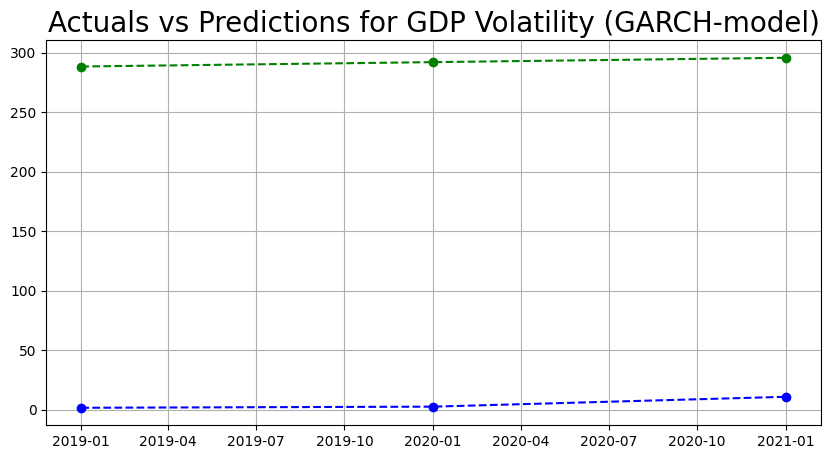

In [70]:
plt.rcParams["figure.figsize"] = 10, 5

plt.plot(predictions_df["gdp_vol"].abs(), color="blue", linestyle="--", marker='o')
plt.plot(predictions_df["Predictions"], color="green", linestyle="--", marker='o')
plt.title("Actuals vs Predictions for GDP Volatility (GARCH-model)", size=20)
plt.grid()
plt.show()

In [65]:
print("Абсолютная ошибка (MAE): ", mean_absolute_error(
    predictions_df["gdp_vol"], predictions_df["Predictions"]
))

print("Абсолютная ошибка в процентах (MAPE): ", mean_absolute_percentage_error(
    predictions_df["gdp_vol"], predictions_df["Predictions"])*100)

Абсолютная ошибка (MAE):  287.19388513424934
Абсолютная ошибка в процентах (MAPE):  10948.780041759255


Видим, что метрика MAPE имеет очень большое значение, это значит, мы получили плохой прогноз волатильности. 

3.3. Воспользуемся линейной регрессией для получения прогноза.

In [66]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    : X_train.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    X_train.shape[0] :
].fillna(0)
#display(X_train)
#display(X_test)
y_train = data["gdp_vol"][:X_train.shape[0]].fillna(0)
y_test = data["gdp_vol"][X_train.shape[0]:].fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

3.4., 3.5 Визуализируем полученное предсказание вместе с фактическим значением. Сравним результаты и сделаем выводы.

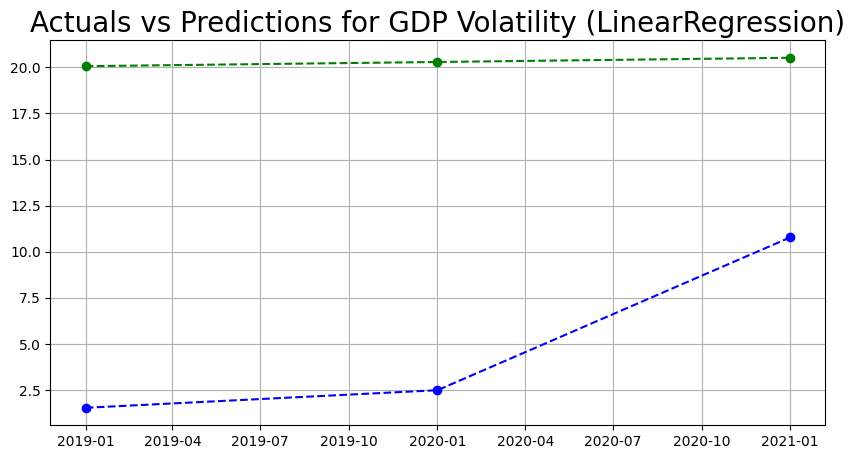

In [71]:
plt.plot(y_test, color="blue", linestyle="--", marker='o')
plt.plot(pd.Series(lr_predict, index=y_test.index), color="green", linestyle="--", marker='o')
plt.title("Actuals vs Predictions for GDP Volatility (LinearRegression)", size=20)
plt.grid()
plt.show()

In [68]:
print("Абсолютная ошибка (MAE): ", mean_absolute_error(
    y_test, pd.Series(lr_predict, index=y_test.index)
))

print("Абсолютная ошибка в процентах (MAPE): ", mean_absolute_percentage_error(
    y_test, pd.Series(lr_predict, index=y_test.index))*100)

Абсолютная ошибка (MAE):  15.348198160106621
Абсолютная ошибка в процентах (MAPE):  667.8132822200257


При использовании линейной регрессии для предсказания волатильности ВВП, так же (как и при использовании GARCH -модели) получили большое значение метрики MARE, т.е. наше предсказание нельзя считать хорошим.

3.6. Почему результат модели GARCH получился именно таким?

При прогнозировании волатильности с применением GARCH-модели мы получили большие значения для нашего предсказания. Это связано с тем что данная модель для расчета предсказаний использует квадрат предыдущих значений во времени и предыдущие оценки дисперсии. Именно большие значения такой характористики как ВВП (числа порядка $10^9$ и больше) внесли свой вклад в предсказанные значения волатильности временного ряда.